In [1]:
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")

import numpy as np
import os
import copy
from astropy.io import fits
import galsim
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import rotate
import tfCube
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts


In [31]:
# to make things practical during testing, increase the spaxel size.
pars = tfCube.getParams(redshift = 0.0)
pars['nm_per_pixel'] = 0.033 
pars['expTime'] = 3600.
pars['pixScale'] = 0.1185  # 0.032 arcsec/pixel
pars['Resolution'] = 6000.  # spectroscopic resolution
pars['sini'] = 0.99
pars['aspect'] = 0.2
pars['vcirc'] = 200.
pars['area'] = 3.14*(1000./2.)**2
pars['linelist']['flux'][pars['linelist']['species'] == 'Halpha'] = 6e-24
pars['lambda_min'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] - 2
pars['lambda_max'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] + 2

lines = pars['linelist']
pars['half_light_radius'] = 0.5
#lines['flux'] = 1e-25
pars['linelist'] = lines
pars['slitAngles'] = np.array([0.])
pars['slitWidth'] = 0.05
# define some fiber parameters
#nfiber = 5
#r_off = 1.5
pars['fiber_size'] = 1.0
pars['psfFWHM'] = .5
pars['vscale'] = 0.5
pars['ngrid'] = 256
pars['image_size'] = 128

In [32]:
c_kms = 2.99792458e5 # c, in km/s
extent =  pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']

In [33]:
#aperture = galsim.Image(128, 128,scale=0.016)
aperture = galsim.Image(pars['ngrid'], pars['ngrid'],scale=subGridPixScale)
offset = [0.,0.]

In [34]:
pars_more = pars.copy()
pars_more['lambda_min'] = pars['lambda_min']*0.8
pars_more['lambda_max'] = pars['lambda_max']*1.2
norm = pars['norm']
spec = tfCube.getGalaxySpectrum(pars_more,norm=norm)

specPh = tfCube.convertToPhotons(spec)
specPh = tfCube.transmit(specPh)

obsLambda = np.arange(pars['lambda_min'],pars['lambda_max'],pars['nm_per_pixel'])
specInterp = interp1d(specPh['lambda'],specPh['photonRate'],kind='slinear')
obsSpecPh = np.empty(specPh.size,dtype=[('lambda',np.float),('photonRate',np.float)])
obsSpecPh['lambda'] = specPh['lambda']
obsSpecPh['photonRate'] = ( specInterp(specPh['lambda'])*
                            pars['expTime']*pars['area']*
                            pars['throughput']*pars['pixScale']**2 *
                            pars['nm_per_pixel'] )
obsInterp = interp1d(obsSpecPh['lambda'],obsSpecPh['photonRate'],kind='slinear')

skySpec = ( tfCube.getSky(obsLambda, specPh) *
                pars['expTime']*pars['area']*
                pars['throughput']*
                pars['pixScale']**2 *
                pars['nm_per_pixel'])

In [35]:
# make the velocity field parameters
c_kms = 2.99792458e5 # c, in km/s
extent =  pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']
grid1d = np.linspace(-extent/2.,extent/2.,pars['ngrid'])
xx,yy = np.meshgrid(grid1d, grid1d)
r = np.sqrt(xx**2 + yy**2)
theta = np.angle(xx+1j*yy)

In [36]:
# Generate the galaxy image that goes with this.
galIm,galObj,psf = tfCube.getGalaxySlice(pars)
lambda_1d = np.arange(pars['lambda_min'],pars['lambda_max'],pars['nm_per_pixel'])
fluxGrid = np.empty([pars['ngrid'],pars['ngrid'],obsLambda.size])
phi = tfCube.getPhi(theta,pars=pars)
v = pars['vcirc'] * np.arctan(r/pars['vscale']) * (2/ (np.pi * c_kms) )    
# v is actually in unit of redshift here ... 

In [37]:
for i,x in enumerate(grid1d):
    for j,y in enumerate(grid1d):
        # This line here is where the disk velocity field enters.
        thisLambda = 1./(1 +   v[i,j] *pars['sini']*np.cos(phi[i,j])) * obsLambda
        thisSpec = obsInterp(thisLambda)*galIm.array[i,j] # this is the unsheared thing.
        fluxGrid[i,j,:] = thisSpec # currently in units of photon flux
# Shear the results and project them onto the output grid.
idealGrid = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])
obsGrid   = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])
skyGrid   = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])

psf = psf.shear(g1=pars['psf_g1'],g2 = pars['psf_g2'])
#psf = psf.dilate(1.02)
psfInv = galsim.Deconvolve(psf)

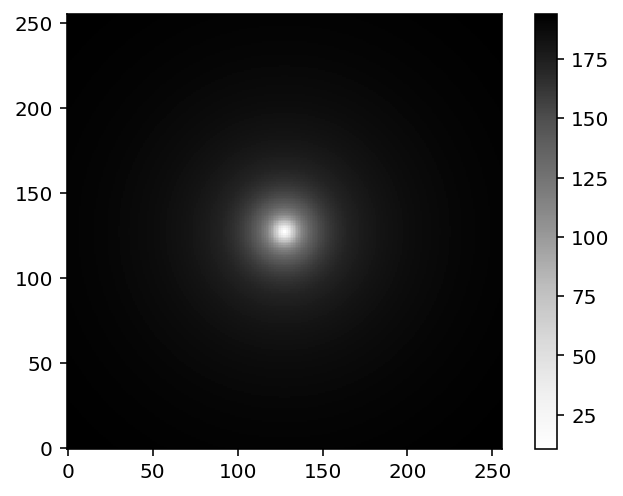

In [38]:
%matplotlib inline
plt.imshow(v*c_kms,cmap=plt.cm.Greys,origin="lower")
plt.colorbar()

In [39]:
v_kms_1d = v[128,:]*c_kms
grid_pos = np.arange(-extent/2., extent/2., subGridPixScale)

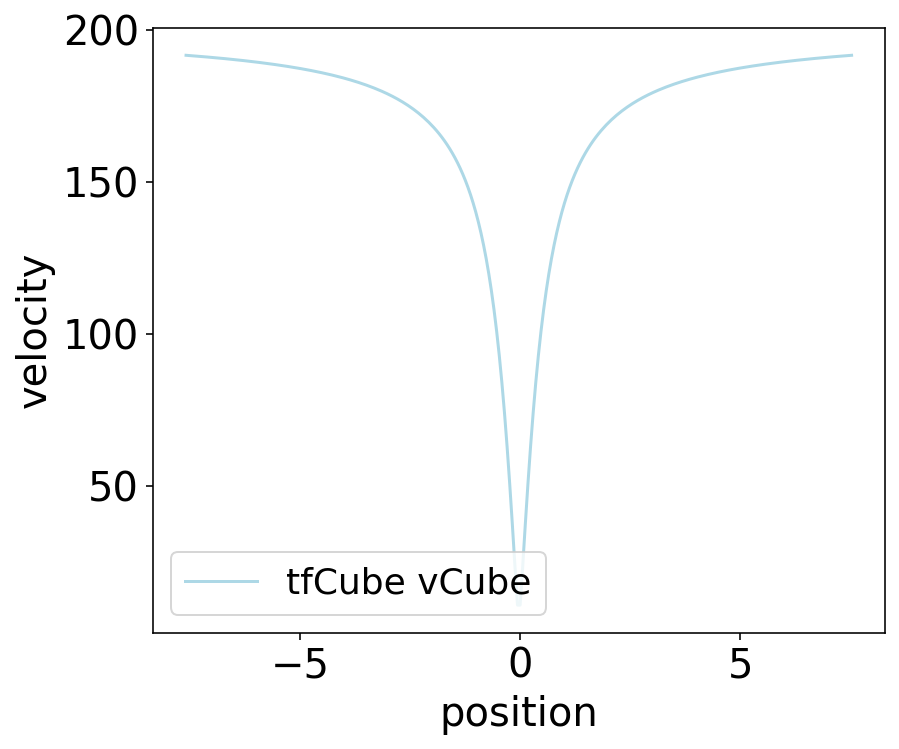

In [55]:
%matplotlib inline
fig = plt.figure(figsize=(6.2,5.))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos,v_kms_1d,label='tfCube vCube',color='lightblue')


ax1.set_xlabel('position')
ax1.set_ylabel('velocity')

ax1.legend(loc='best',prop={'size':18})

In [41]:
v.shape

(256, 256)

In [52]:
r = 50
i = 128
j = 128+r
thisLambda = 1./(1 +   v[i,j] *pars['sini']*np.cos(phi[i,j])) * obsLambda 
# the redshifted lambda at a given pixel

print('v[128,128+r]:',v[i,j]*c_kms)
print('np.cos(phi[128,128+r]):',np.cos(phi[i,j]))
print('v cos(phi):',v[i,j]*c_kms*np.cos(phi[i,j]))

print('\n')

j = 128-r
thisLambda = 1./(1 +   v[i,j] *pars['sini']*np.cos(phi[i,j])) * obsLambda 
print('v[128,128-r]:',v[i,j]*c_kms)
print('v cos(phi):',v[i,j]*c_kms*np.cos(phi[i,j]))
print('v cos(phi):',v[i,j]*c_kms*np.cos(phi[i,j]))

v[128,128+r]: 179.00015270533552
np.cos(phi[128,128+r]): 0.9975460073664589
v cos(phi): 178.56088764919392


v[128,128-r]: 178.58383551513708
v cos(phi): -178.1277748933814
v cos(phi): -178.1277748933814


v[128,128+r]: 179.00015270533552
np.cos(phi[128,128+r]): 0.9975460073664589
v cos(phi): 178.56088764919392
v[128,128-r]: 178.58383551513708
v cos(phi): -178.1277748933814
v cos(phi): -178.1277748933814


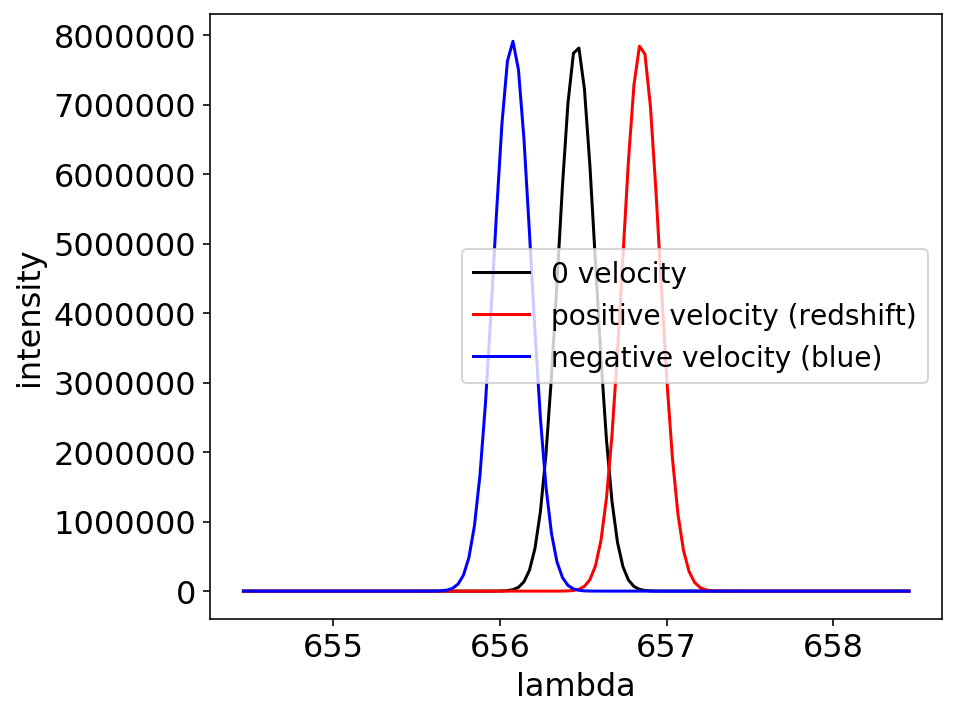

In [71]:
%matplotlib inline
fig = plt.figure(figsize=(6.2,5.))
plt.rc('font',size=16)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(obsLambda,obsInterp(obsLambda),label='0 velocity',color='k')

# positive velocity
r = 50
i = 128
j = 128+r
thisLambda = 1./(1 +   v[i,j] *pars['sini']*np.cos(phi[i,j])) * obsLambda 

print('v[128,128+r]:',v[i,j]*c_kms)
print('np.cos(phi[128,128+r]):',np.cos(phi[i,j]))
print('v cos(phi):',v[i,j]*c_kms*np.cos(phi[i,j]))

ax1.plot(obsLambda,obsInterp(thisLambda),label='positive velocity (redshift)',color='red')

# negative velocity
j = 128-r
thisLambda = 1./(1 +   v[i,j] *pars['sini']*np.cos(phi[i,j])) * obsLambda 
print('v[128,128-r]:',v[i,j]*c_kms)
print('v cos(phi):',v[i,j]*c_kms*np.cos(phi[i,j]))
print('v cos(phi):',v[i,j]*c_kms*np.cos(phi[i,j]))

ax1.plot(obsLambda,obsInterp(thisLambda),label='negative velocity (blue)',color='b')


ax1.set_xlabel('lambda')
ax1.set_ylabel('intensity')

ax1.legend(loc='best',prop={'size':14})

In [64]:
thisSpec = obsInterp(thisLambda)*galIm.array[i,j]
thisSpec

array([7.76744238e-045, 5.74191035e-043, 3.88088200e-041, 2.39839224e-039,
       1.35533514e-037, 7.00376763e-036, 3.30977092e-034, 1.43043688e-032,
       5.65415955e-031, 2.04418701e-029, 6.76007390e-028, 2.04496502e-026,
       5.65912728e-025, 1.43274097e-023, 3.31868348e-022, 7.03345630e-021,
       1.36395739e-019, 2.42038934e-018, 3.93046876e-017, 5.84115965e-016,
       7.94453994e-015, 9.88942191e-014, 1.12673305e-012, 1.17498523e-011,
       1.12154291e-010, 9.79895610e-010, 7.83663870e-009, 5.73678863e-008,
       3.84412080e-007, 2.35782585e-006, 1.32375487e-005, 6.80262498e-005,
       3.19969091e-004, 1.37749202e-003, 5.42755859e-003, 1.95720851e-002,
       6.45903720e-002, 1.95063489e-001, 5.39063289e-001, 1.36312614e+000,
       3.15384942e+000, 6.67620925e+000, 1.29293906e+001, 2.29065744e+001,
       3.71236820e+001, 5.50333235e+001, 7.46207380e+001, 9.25397229e+001,
       1.04956182e+002, 1.08861925e+002, 1.03254713e+002, 8.95546567e+001,
       7.10215708e+001, 5